# The Impact of Lower Interest Rates in Brazilian Stock Market

*By Daniel Deutsch, José Lucas Barretto, Kevin kühl and Lucas Miguel Agrizzi*

In [1]:
import os
import time
from datetime import date
from io import BytesIO
from zipfile import ZipFile

import matplotlib.pyplot as plt
import pandas as pd
import requests
import yfinance as yf
from requests.packages.urllib3.exceptions import InsecureRequestWarning

In [2]:
# Warnings
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Data Collection

In this stage, we want to collect the data necessary for our analysis. In our case, we must collect two kinds of data: brazilian economic sector indexes (our explained variables) and other variables that we believe might have some influence over the indexes (the explanatory variables).

## Explained Variables

### Sector Indexes

An economic index is basically a statistic about an economic activity. Economic indexes allow analysis of economic performance and forecasts of future performance. Therefore, sector indexes are a great way to understand the performance of a certain sector of the economy (such as electricity, basic materials, etc.) in the stock market.

Given that, the group decided to understand the effects of lower interest rates on the following indexes, considered by us the most influential in the brazillian market:

| Index &emsp;  | Index Name                         | Sector           |
|:--------------|:-----------------------------------|:-----------------|
| `ICON`        | Índice de Consumo                  | Cyclical consumption, non-cyclical consumption and health |
| `IEEX`        | Índice de Energia Elétrica &emsp;  | Electricity |
| `IFNC`        | Índice Financeiro                  | Financial intermediaries, miscellaneous financial services, pension and insurance |
| `IMAT`        | Índice de Materiais Básicos        | Basic materials |
| `IMOB`        | Índice Imobiliário                 | Real estate and civil construction |
| `INDX`        | Índice Industrial                  | Basic materials, industrial goods, cyclical consumption, non-cyclical consumption, information technology and health |
| `UTIL`        | Índice Utilidade Pública           | Electricity, water and sanitation and gas |

In [6]:
indexes = [
    { 'index': "ICON", 'url_code': "klDT04" },
    { 'index': "IEEX", 'url_code': "klFRVg" },
    { 'index': "IFNC", 'url_code': "klGTkM" },
    { 'index': "IMAT", 'url_code': "klNQVQ" },
    { 'index': "IMOB", 'url_code': "klNT0I" },
    { 'index': "INDX", 'url_code': "klORFg" },
    { 'index': "UTIL", 'url_code': "lVUSUw" }
]

years = [
    { 'year': "2021", 'url_code': "IwMjE" },
    { 'year': "2020", 'url_code': "IwMjA" },
    { 'year': "2019", 'url_code': "IwMTk" },
    { 'year': "2018", 'url_code': "IwMTg" },
    { 'year': "2017", 'url_code': "IwMTc" },
    { 'year': "2016", 'url_code': "IwMTY" },
    { 'year': "2015", 'url_code': "IwMTU" },
    { 'year': "2014", 'url_code': "IwMTQ" },
    { 'year': "2013", 'url_code': "IwMTM" },
    { 'year': "2012", 'url_code': "IwMTI" },
    { 'year': "2011", 'url_code': "IwMTE" },
    { 'year': "2010", 'url_code': "IwMTA" },
    { 'year': "2009", 'url_code': "IwMDk" },
    { 'year': "2008", 'url_code': "IwMDg" },
    { 'year': "2007", 'url_code': "IwMDc" },
    { 'year': "2006", 'url_code': "IwMDY" },
    { 'year': "2005", 'url_code': "IwMDU" },
    { 'year': "2004", 'url_code': "IwMDQ" },
    { 'year': "2003", 'url_code': "IwMDM" },
    { 'year': "2002", 'url_code': "IwMDI" },
    { 'year': "2001", 'url_code': "IwMDE" },
    { 'year': "2000", 'url_code': "IwMDA" },
    { 'year': "1999", 'url_code': "E5OTk" },
    { 'year': "1998", 'url_code': "E5OTg" }
]

url_sectors = "https://sistemaswebb3-listados.b3.com.br/indexStatisticsProxy/IndexCall/GetPortfolioDay/eyJpbmRleCI6I%siLCJsYW5ndWFnZSI6InB0LWJyIiwieWVhciI6Ij%sifQ=="

for i_id, index in enumerate(indexes):
    df_index = pd.DataFrame()
    for y_id, year in enumerate(years):
        r = requests.get(url_sectors % (index['url_code'], year['url_code']), verify=False)
        try:
            print(f"\rProgress indexes {i_id+1}/{len(indexes)} years {y_id+1}/{len(years)} df_index_size {df_index.shape[0]}", end="")
            r = r.json()
        except Exception:
            print(f"Error with index {index['index']} year {year['year']}")
        else:
            if r['results']:
                for result in r['results']:
                    day = result['day']
                    for key, val in result.items():
                        if key != "day":
                            date = f"{year['year']}-{int(key[9:]):02d}-{day:02d}"
                            rate_value = float(val.replace('.', '').replace(',', '.')) if val else pd.NA
                            df_new = pd.DataFrame({ 'date': [date], 'index': [index['index']], 'rate_value': [rate_value] })
                            df_index = pd.concat([df_index, df_new], ignore_index=True)
                            
    df_index.dropna(inplace=True)
    df_index['date'] = pd.to_datetime(df_index['date'])
    df_index.sort_values(by=['date', 'index', 'rate_value'], inplace=True, ignore_index=True)
    df_index.to_csv(f"./datasets/raw/explained/{index['index']}.csv.zip")

Progress indexes 7/7 years 24/24 df_index_size 6324

## Explanatory Variables

### Interest Rate (SELIC)

The SELIC is the basic rate of the economy and serves as a reference for other interest rates (financing) and for remunerating investments corrected by it.

In [7]:
url_selic = "http://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=csv"
df_selic = pd.read_csv(
    url_selic, 
    delimiter=';',
    header=0, 
    names = ['date', 'rate_value'], 
    decimal=',',
    parse_dates=[0]
)
df_selic['index'] = "selic"
df_selic.sort_values(by=['date', 'index', 'rate_value'], inplace=True, ignore_index=True)
df_selic.to_csv(f"./datasets/raw/explanatory/selic.csv.zip")

### Volatility Index

Volatility, in the financial area, is a measure of dispersion of the returns of a security or market index. The more the price of a stock varies in a short period of time, the greater the risk of making or losing money by trading in that stock - therefore, volatility is a measure of risk.

In [8]:
df_vix = yf.download('^VIX', period='max', interval='1d')
df_vix.reset_index(level=0, inplace=True)
df_vix.rename(columns={'Adj Close': 'rate_value', 'Date': 'date'}, inplace=True)
df_vix = df_vix[:][['date', 'rate_value']]
df_vix['index'] = "vix"
df_vix.sort_values(by=['date', 'index', 'rate_value'], inplace=True, ignore_index=True)
df_vix.to_csv(f"./datasets/raw/explanatory/vix.csv.zip")

[*********************100%***********************]  1 of 1 completed


### Price of the Dollar

The price of the dollar is basically how much 1 american dollar is worth in reais (brazilian currency) at a given day.

In [9]:
df_dollar = yf.download("BRL=X", period='max', interval='1d')
df_dollar.reset_index(level=0, inplace=True)
df_dollar.rename(columns={'Adj Close': 'rate_value', 'Date': 'date'}, inplace=True)
df_dollar = df_dollar[:][['date', 'rate_value']]
df_dollar['index'] = "dollar"
df_dollar.sort_values(by=['date', 'index', 'rate_value'], inplace=True, ignore_index=True)
df_dollar.to_csv(f"./datasets/raw/explanatory/dollar.csv.zip")

[*********************100%***********************]  1 of 1 completed


### Inflation Rate (IPCA)

Consumer price index is used to track inflation trends. It is calculated based on the average price needed to buy a set of consumer goods and services in a country, compared to previous periods.

In [10]:
url_ipca = "https://apisidra.ibge.gov.br/values/t/1737/n1/all/v/all/p/all/d/v63%202,v69%202,v2266%2013,v2263%202,v2264%202,v2265%202?formato=json"

df_ipca = pd.read_json(url_ipca)
df_ipca.drop([0], inplace=True)

mask = (df_ipca['MN'] == "%")
df_ipca = df_ipca[mask]

df_ipca.rename(columns={'D3C': 'date'}, inplace=True)
df_ipca['date'] = pd.to_datetime(df_ipca['date'], format='%Y%m')
df_ipca['V'] = pd.to_numeric(df_ipca['V'])

mask = (df_ipca['D2N'] == "IPCA - Variação mensal")
ipca_pct_change = df_ipca[mask][['date', 'V']].rename(columns={'V': 'rate_value'})
ipca_pct_change['index'] = 'ipca_pct'

mask = (df_ipca['D2N'] == "IPCA - Variação acumulada no ano")
ipca_annual_cumulative = df_ipca[mask][['date', 'V']].rename(columns={'V': 'rate_value'})
ipca_annual_cumulative['index'] = "ipca_cum"

df_ipca = pd.concat([ipca_pct_change, ipca_annual_cumulative], axis=0)
df_ipca.sort_values(by=['date', 'index', 'rate_value'], inplace=True, ignore_index=True)
df_ipca.to_csv(f"./datasets/raw/explanatory/ipca.csv.zip")

### GDP

Gross Domestic Product represents the sum of all final goods and services produced in a given region, over a given period. GDP is one of the most used indicators in macroeconomics with the objective of quantifying the economic activity of a region.

In [11]:
gdp_url = "https://ftp.ibge.gov.br/Contas_Nacionais/Contas_Nacionais_Trimestrais/Tabelas_Completas/Tab_Compl_CNT.zip"

file = ZipFile(BytesIO(requests.get(gdp_url, verify=False).content))
xlfile = file.open("Tab_Compl_CNT_4T20.xls")

df_gdp = pd.read_excel(
    xlfile, 
    sheet_name='Valores Correntes',
    usecols=[0, 17],
    names=['date', 'rate_value'],
    skiprows=3,
    parse_dates=[0]
)

mask = df_gdp.date.str.findall('[0-9]+\.[A-Z]+').apply(lambda arr: arr != [])
df_gdp = df_gdp[mask].reset_index(drop=True)

dates = pd.date_range(start='1996', end='2021', freq='Q')
df_gdp['date'] = dates
df_gdp['index'] = "gdp"
df_gdp.sort_values(by=['date', 'index', 'rate_value'], inplace=True, ignore_index=True)
df_gdp.to_csv(f"./datasets/raw/explanatory/gdp.csv.zip")

# Data Processing

Unfortunately the collected data isn't in the prper format for our analysis since some frequencies doesn't match and some variables have missing data. Therefore, it is important to process the data to facilitate our analysis.

In [99]:
# Read Explained variables
df_icon = pd.read_csv("./datasets/raw/explained/ICON.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])
df_ieex = pd.read_csv("./datasets/raw/explained/IEEX.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])
df_ifnc = pd.read_csv("./datasets/raw/explained/IFNC.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])
df_imat = pd.read_csv("./datasets/raw/explained/IMAT.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])
df_imob = pd.read_csv("./datasets/raw/explained/IMOB.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])
df_indx = pd.read_csv("./datasets/raw/explained/INDX.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])
df_util = pd.read_csv("./datasets/raw/explained/UTIL.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])

# Read explanatory variables
df_dollar = pd.read_csv("./datasets/raw/explanatory/dollar.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])
df_gdp = pd.read_csv("./datasets/raw/explanatory/gdp.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])
df_ipca = pd.read_csv("./datasets/raw/explanatory/ipca.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])
df_selic = pd.read_csv("./datasets/raw/explanatory/selic.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])
df_vix = pd.read_csv("./datasets/raw/explanatory/vix.csv.zip", usecols=['date', 'rate_value'], parse_dates=["date"])

## Resample 

All the data collected has a daily frequency except the GDP (quarterly) and the IPCA (monthly) therefore, we need to change their frequency to make their analysis possible.

In [100]:
# Resamples the GDP dataframe to a daily frequency (repeats the month value to its days)
df_gdp = df_gdp.set_index('date').resample('D').ffill().reset_index()

# Resamples the IPCA dataframe to a daily frequency (repeats the quarter value to its days)
df_ipca = df_ipca.set_index('date').resample('D').ffill().reset_index()

## Filter Date Intervals

Since we have variables that started to be measured in different moments, we need to find a common ground. To do so, we will only run our analysis in the inner join of all the dataframes.

In [101]:
# Performas an inner join with all dataframes (select only common dates)
df = pd.merge(df_icon, df_ieex, how='inner', on='date')
df = pd.merge(df, df_ifnc, how='inner', on='date')
df = pd.merge(df, df_imat, how='inner', on='date')
df = pd.merge(df, df_imob, how='inner', on='date')
df = pd.merge(df, df_indx, how='inner', on='date')
df = pd.merge(df, df_util, how='inner', on='date')
df = pd.merge(df, df_dollar, how='inner', on='date')
df = pd.merge(df, df_gdp, how='inner', on='date')
df = pd.merge(df, df_ipca, how='inner', on='date')
df = pd.merge(df, df_selic, how='inner', on='date')
df = pd.merge(df, df_vix, how='inner', on='date')

# Rename columns
df.columns = ["date", "ICON", "IEEX", "IFNC", "IMAT", "IMOB", "INDX", "UTIL", "DOLLAR", "GDP", "IPCA", "SELIC", "VIX"]

# Save the processed dataframe
df.to_csv("./datasets/proc/variables.csv.zip")

# Data Visualization

## Plotting Covariate Data

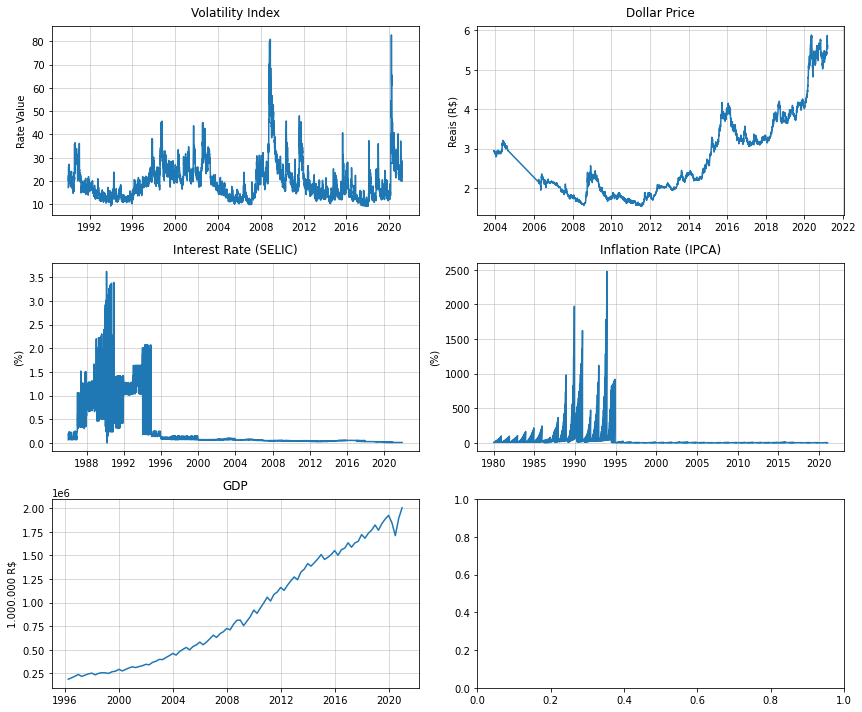

In [37]:
fig, ax = plt.subplots(3,2, figsize=(12,10))

ax[0,0].plot(df_vix['date'], df_vix['rate_value'])
ax[0,0].set_title('Volatility Index', pad=10)
ax[0,0].set_ylabel('Rate Value', labelpad=5)
ax[0,0].grid(alpha=0.6)

ax[0,1].plot(df_dollar['date'], df_dollar['rate_value'])
ax[0,1].set_title('Dollar Price', pad=10)
ax[0,1].set_ylabel('Reais (R$)', labelpad=5)
ax[0,1].grid(alpha=0.6)

ax[1,0].plot(df_selic['date'], df_selic['rate_value'])
ax[1,0].set_title('Interest Rate (SELIC)', pad=10)
ax[1,0].set_ylabel('(%)', labelpad=5)
ax[1,0].grid(alpha=0.6)

ax[1,1].plot(df_ipca['date'], df_ipca['rate_value'])
ax[1,1].set_title('Inflation Rate (IPCA)', pad=10)
ax[1,1].set_ylabel('(%)', labelpad=5)
ax[1,1].grid(alpha=0.6)

ax[2,0].plot(df_gdp['date'], df_gdp['rate_value'])
ax[2,0].set_title('GDP', pad=10)
ax[2,0].set_ylabel('1.000.000 R$', labelpad=5)
ax[2,0].grid(alpha=0.6)

plt.tight_layout()
plt.show()

## Plotting Explained Variables

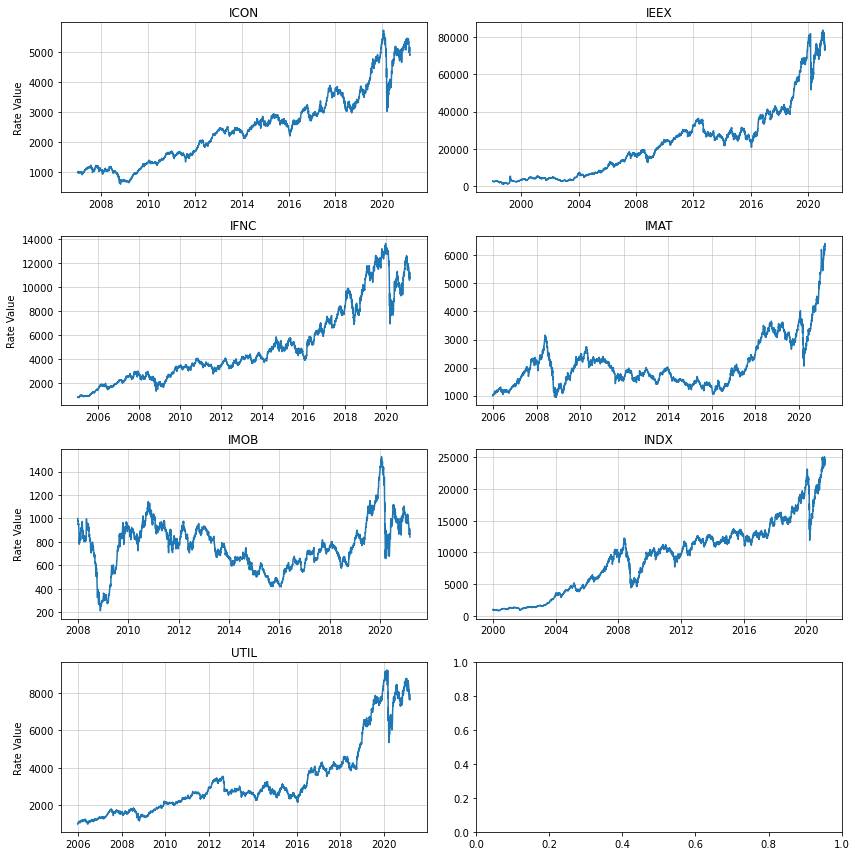

In [99]:
# df = pd.read_csv("./datasets/sector_indexes.csv.zip", index_col=0)
# df['date'] = pd.to_datetime(df['date'])

g = df.groupby('index')

fig, axes = plt.subplots(g.ngroups//2+1, 2, figsize=(12, 12))

for i, (index, data) in enumerate(g):
    ax=axes[i//2, i%2]
    ax.plot(data['date'], data['rate_value'])
    ax.set_title(index)
    ax.grid(alpha=0.6)
    
    if i%2 == 0:
        ax.set_ylabel('Rate Value', labelpad=5)

plt.tight_layout()
plt.show()

# Data Analysis